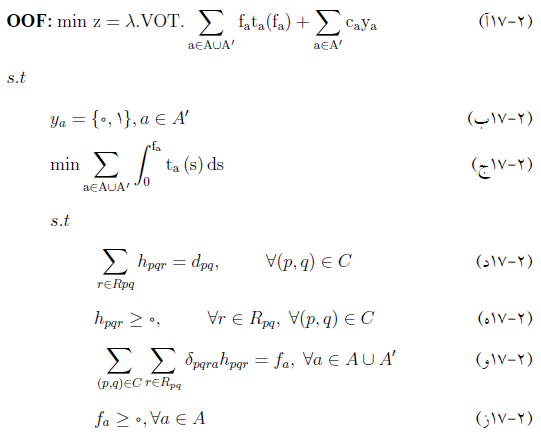

In [5]:
#!pyomo help --solvers
from pyomo.environ import *
import numpy as np
from scipy.sparse import csr_matrix

#---محدودیت سطح بالا
def consBudjet(LIP): 
    return summation(LIP.c, LIP.y) <= LIP.B

    #محدودیت 5 :  مجموع جریانهای تمام مسیرهای بین یک زوج برابر است با تقاضای بین آن زوج
def TapPyomocons5(Model,i):
        return sum( Model.deltaod[i,j] * Model._fijk[j] for j in Model.setpath) == Model.OdDeman[i]
        

def TapPyomocons6(Model,i):#محدودیت 6: جریان یک لینک برابر است با مجموع جریانهای مربوط به تمام مسیرهای تمام زوجها که این لینک عضو آن است
        return Model._ve[i] == sum( Model.deltalnk[i,j] * Model._fijk[j]  for j in Model.setpath) 

def TapPyomofobjective(Model):
        return sum(Model.LinkFreeFlowTime[e]*(Model._ve[e]+( (0.03*(Model._ve[e]**5))/(Model.linkcap[e]**4)) ) for e in Model.setlink)

    
    
def sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector):
        DeltaOD_Matrix_Dict = dict(DeltaOD_Matrix.todok().items()) # convert to dictionary of keys format
                        
        DeltaLink_Matrix_Dict = dict(DeltaLink_Matrix.todok().items()) # convert to dictionary of keys format
 
        Model = AbstractModel()
        # sets
        Model.setpath = range(PathCount)
        Model.setlink = range(LinkCount)
        Model.setod = range(ODCount)
        Model.A = range(3)
        
        Model.OdDeman = Param(Model.setod, initialize= dict(enumerate(ODDeman_Vector.flatten(), 0)))
        Model.LinkFreeFlowTime = Param(Model.setlink, initialize=dict(enumerate(LinkFreeFlowTime_Vector, 0)))
        Model.linkcap = Param(Model.setlink, initialize=dict(enumerate(LinkCap_Vector, 0)))
        
       
        #برای تعریف ماتریس اسپارس باید مقدار دیفالت را برابر با یک عدد قرار دهیم که بیشترین تکرار را دارد و باقی را با یک دیکشنری مقداردهی اولیه کنیم
        Model.deltaod = Param(Model.setod,Model.setpath,default=0, initialize=DeltaOD_Matrix_Dict)
        Model.deltalnk = Param(Model.setlink,Model.setpath,default=0, initialize=DeltaLink_Matrix_Dict)


        Model._fijk = Var(Model.setpath,within=NonNegativeReals)# جریان بین زوج آی و جی از مسیر کاام بین آنها
        Model._ve = Var(Model.setlink,within=NonNegativeReals) #جریان هر یک از لنیکها(یالها)
        Model.con5=Constraint(Model.setod,rule=TapPyomocons5)
        Model.con6=Constraint(Model.setlink,rule=TapPyomocons6)

        Model.obj = Objective(rule=TapPyomofobjective,sense=minimize)
        opt = SolverFactory('ipopt')
        instance = Model.create_instance()

        results = opt.solve(instance)
        #instance.con5.pprint()
        #instance.con6.pprint()
        #instance.deltaod.pprint()

        #instance.display()
        tmp = np.zeros(len(instance._ve))
        for r in range(len(instance._ve)):
            tmp[r] =instance._ve[r].value
        return list(tmp)

In [3]:
#دیدن تمام المانهای داخل ماتریس اسپارس

#DeltaOD_Matrix.toarray()


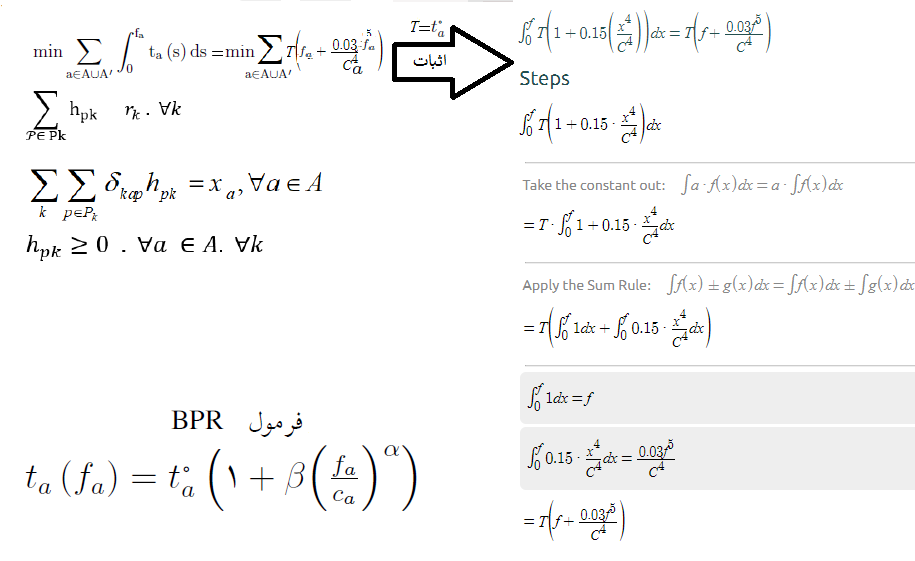